# Solving SIR model with PINN

In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import numpy as np
from tqdm import tqdm

## Define Neural Network

In [2]:
class PINN(nn.Module):
    def __init__(self, layers, beta=0.15, gamma=1/14):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        
        # Define the layers
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
            
        self.activation = nn.ReLU()

        self.beta = beta
        self.gamma = gamma

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = self.activation(layer(x))
        return x
    
    def u(self, t):
        u = self.forward(t)
        return u

    def f(self, t):
        u = self.u(t)
        
        # Compute first derivative u_t
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]

        # Define the PDE residual of SIR model u = [S, I, R]
        S = u[:, 0:1]
        I = u[:, 1:2]
        R = u[:, 2:3]
        f = torch.cat([
            u_t[:, 0:1] - self.beta * S * I,
            u_t[:, 1:2] + self.beta * S * I - self.gamma * I,
            u_t[:, 2:3] - self.gamma * I
        ], dim=1)
        return f
    
    def n(self, t):
        u = self.u(t)
        S = u[:, 0:1]
        I = u[:, 1:2]
        R = u[:, 2:3]
        return S + I + R - 1

## Prepare Data

In [3]:
def prepare_data():
    N_f = 1000 # Number of collocation points for PDE

    # Initial condition: u(0) = [1, 0.01, 0]
    t_ic = torch.zeros(1, 1).requires_grad_(True)
    u_ic = torch.tensor([[0.9, 0.1, 0]], dtype=torch.float32).requires_grad_(True)


    # Collocation points for ODE
    t_f = torch.linspace(0, 100, N_f).reshape(-1, 1).requires_grad_(True)

    return dict(t_ic=t_ic, u_ic=u_ic, t_f=t_f) 

## Setup Training Loop

In [4]:
def train_pinn(model, optimizer, epochs, data, use_gpu=True):
    
    # Check if GPU is available and use it if `use_gpu` is True
    device = torch.device("cuda" if use_gpu and torch.cuda.is_available() else "cpu")
    if use_gpu and not torch.cuda.is_available():
        print("GPU is not available, training on CPU instead.")
    else:
        print(f"Training on {str(device).upper()}")
    model.to(device)
    
    # Move all tensors to the selected device
    t_ic = data["t_ic"].to(device)
    u_ic = data["u_ic"].to(device)
    t_f = data["t_f"].to(device)
    
    # Initialize tqdm progress bar
    progress_bar = tqdm(range(epochs), desc="Training", unit="epoch")
    
    for _ in progress_bar:
        optimizer.zero_grad()
        
        # Initial condition loss
        u_pred_ic = model.u(t_ic)
        loss_ic = torch.mean((u_pred_ic - u_ic)**2)

        # PDE residual loss
        f_pred = model.f(t_f)
        loss_pde = torch.mean(f_pred**2)

        # Population loss
        n_pred = model.n(t_f)
        loss_pop = torch.mean(n_pred**2)

        # Total loss
        loss = loss_ic + loss_pde + loss_pop
        loss.backward(retain_graph=True)
        optimizer.step()

        # Update the progress bar with current loss
        progress_bar.set_postfix({"Loss": loss.item()})
    
    # Move the model back to the CPU
    model.to("cpu")


In [5]:
# Set parameters
layers = [1, 20, 20, 20, 3]  # Define layers (input layer + hidden layers + output layer)
model = PINN(layers)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
epochs = 5000

# Prepare data
data = prepare_data()

# Train the model
train_pinn(model, optimizer, epochs, data, use_gpu=False)

Training on CPU


Training: 100%|██████████| 5000/5000 [00:29<00:00, 171.29epoch/s, Loss=0.28] 


## Evaluate Model

In [6]:
# Save the model
torch.save(model.state_dict(), "sir.pth")

In [7]:
# Load the model
model = PINN([1, 20, 20, 20, 3])
model.load_state_dict(torch.load("sir.pth"))

C:\Users\jonas\AppData\Local\Temp\ipykernel_17752\3101101976.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("sir.pth"))


<All keys matched successfully>

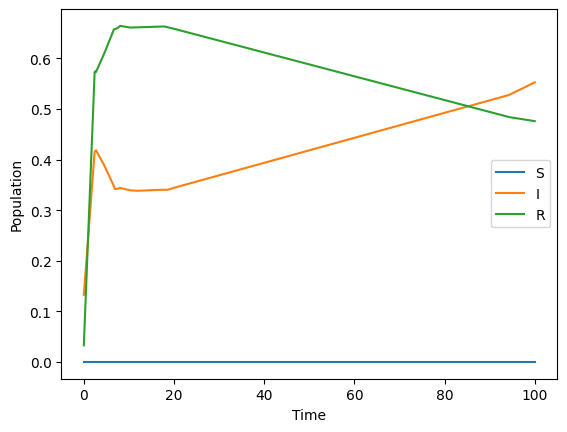

In [8]:
# Evaluate the model on a grid
t = torch.linspace(0, 100, 1000).reshape(-1, 1)

# Predict the solution
u_pred = model.u(t)

# Plot the solution
import matplotlib.pyplot as plt
plt.plot(t, u_pred[:, 0].detach().numpy(), label="S")
plt.plot(t, u_pred[:, 1].detach().numpy(), label="I")
plt.plot(t, u_pred[:, 2].detach().numpy(), label="R")
plt.xlabel("Time")
plt.ylabel("Population")
plt.legend()
plt.show()

